In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [0]:
import importlib
import util
importlib.reload(util)
from util import *

In [0]:
# TODO: test loss and validation loss

In [0]:
loss = torch.nn.MSELoss()

In [0]:
def train_it(dataset, model, learning_rate = 1e-4, Npast=1, Nfuture=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Nepoch = 1000
    Nbatch = 100
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        y_pred = model(xx)+xx
        L = loss(y_pred,yy)
        h = y_pred
        #for i in range(Nfuture-1):
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss(yyt,yt_pred)
            losses[e//Nsave,0] = L.item()
            losses[e//Nsave,1] = test_err.item()
    return losses

In [0]:
stash = {}

In [42]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    for name, cls in models.items():
        print("Training ",name)
        model = cls(Nx).to(device)
        results = train_it(dataset,model)
        stash[name] = {'model':model,
                       'loss':results}

Training  PureStencil
469 0.03963601216673851
939 0.00200735148973763
1409 0.0001733826065901667
1879 0.000265089183812961
2349 0.00024070274957921356
2819 0.0002627719659358263
3289 0.00027606659568846226
3759 0.00026130207697860897
4229 0.0005204282351769507
4699 0.00017044182459358126
Training  PureLinear
469 5.3663036680973164e-08
939 5.713600259582563e-08
1409 6.901895233113464e-08
1879 3.094091027833201e-07
2349 4.9930477530324424e-08
2819 6.964145882193407e-08
3289 1.2078187694442022e-07
3759 1.2886064837402955e-07
4229 3.117466462754237e-07
4699 2.553741751398775e-07
Training  DeepStencil
469 0.00020234445401001722
939 0.00016016370500437915
1409 0.00011156836262671277
1879 0.00016290300118271261
2349 8.411544695263728e-05
2819 5.814369797008112e-05
3289 4.84554075228516e-05
3759 2.7151914764544927e-05
4229 1.5781237379997037e-05
4699 1.0390561328676995e-05
Training  FCMLP
469 1.8734567674982827e-07
939 5.8418489601308465e-08
1409 5.437758332504927e-08
1879 4.412521903418565e-0

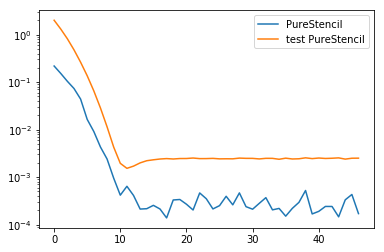

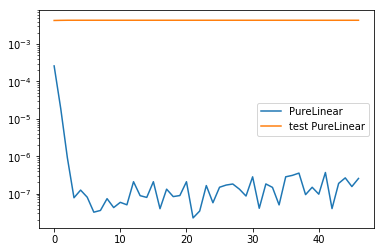

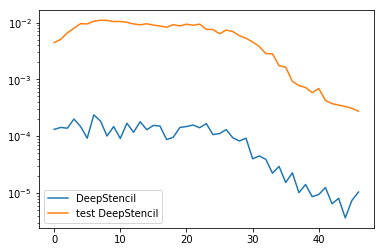

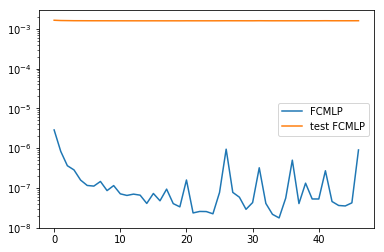

In [43]:
for N,S in stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
    plt.show()

PureStencil


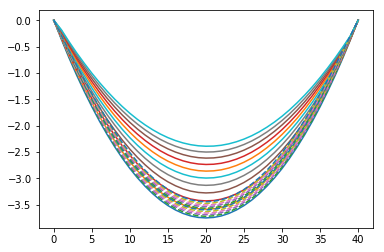

PureLinear


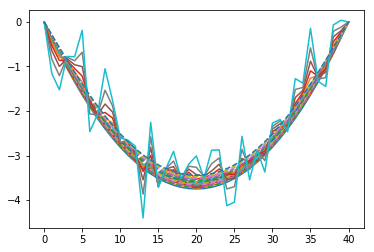

DeepStencil


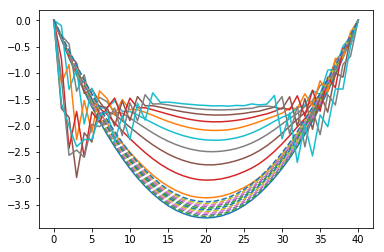

FCMLP


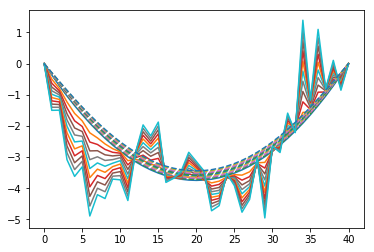

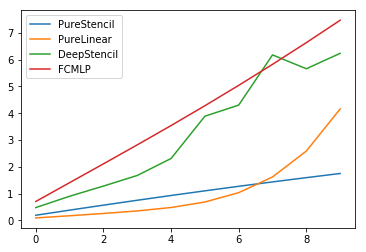

PureStencil


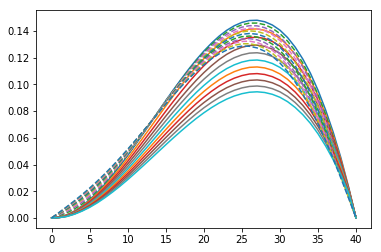

PureLinear


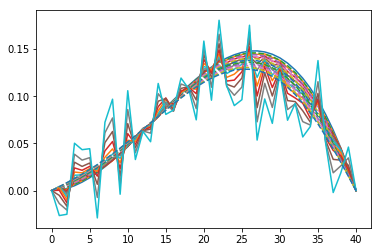

DeepStencil


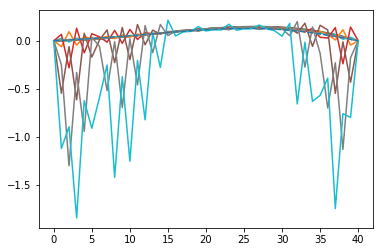

FCMLP


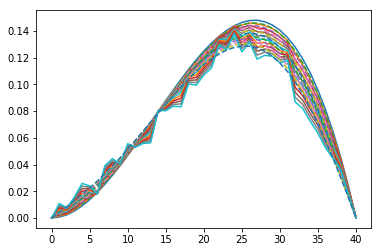

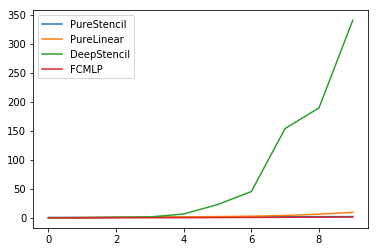

In [44]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,10)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()


In [45]:
list(stash["PureStencil"]['model'].parameters())

[Parameter containing:
 tensor([[[ 0.0035, -0.0291, -0.0185]]], device='cuda:0', requires_grad=True)]

In [0]:
outfile = open(root+'/db','wb')
torch.save(stash,outfile)
outfile.close()